In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd

import sys
sys.path.append('D:/thesis/src')
from two_level_clustering.Utils import RectangularLattice, generate_mixture
from two_level_clustering.SOCEM import SOCEM
from two_level_clustering.PbSOMClustering import PbSOMClustering
from two_level_clustering.Merging import Merging

from sklearn import metrics
mpl.rcParams['figure.dpi'] = 300

### Using synthetic data to benchmark clustering

In [2]:
np.random.seed(42)
# Numbers of epochs for testing
epochs = 100

In [3]:
def model_info(model_labels, true_labels):
    # Function that shows crosstab of cluster and actual labels

    df = pd.DataFrame({'clust_label': model_labels, 'orig_label': true_labels})
    ct = pd.crosstab(df['clust_label'], df['orig_label'])
    display(ct)


def clustering_quality(y_true, y_pred):
    ari = metrics.adjusted_rand_score(y_true, y_pred)
    nmi = metrics.normalized_mutual_info_score(y_true, y_pred)
    ami = metrics.adjusted_mutual_info_score(y_true, y_pred)
    v_measure = metrics.v_measure_score(y_true, y_pred)
    fm_score = metrics.fowlkes_mallows_score(y_true, y_pred)
    
    print("Adjusted Rand Index:", ari)
    print("Normalized Mutual Information:", nmi)
    print("Adjusted Mutual Information:", ami)
    print("V-Measure:", v_measure)
    print("Fowlkes-Mallows Score:", fm_score)
    
    return ari, nmi, ami, v_measure, fm_score

In [26]:
class Algorithm1:
    '''PbSOM + MML + Combining'''

    def __init__(self, lattice, sigma_start, sigma_step, betta, cov_type, tol, max_iter, reg_covar, merge_method, merge_threshold):
        self.lattice = lattice
        self.sigma_start = sigma_start
        self.sigma_step = sigma_step
        self.betta = betta
        self.cov_type = cov_type
        self.tol = tol
        self.max_iter = max_iter
        self.reg_covar = reg_covar
        self.merge_method = merge_method
        self.merge_threshold = merge_threshold

        self.labels_ = None
    
    def fit(self, X):
        pbsom = SOCEM(self.lattice, self.sigma_start, self.sigma_step, self.betta, self.cov_type, self.tol, self.max_iter, reg_covar=self.reg_covar)
        pbsom.fit(X)

        em_reduction = PbSOMClustering(pbsom)
        em_reduction.fit(X)

        weights, means, covs = em_reduction.get_params()
        merging = Merging(weights, means, covs, self.merge_method, self.merge_threshold)
        merging.fit(X)

        self.labels_ = merging.labels_


In [16]:
from sklearn.mixture import GaussianMixture

class Algorithm2:
    '''GMM + BIC + Entropy'''

    def __init__(self, kmin, kmax):
        self.kmin = kmin
        self.kmax = kmax

        self.labels_ = None
    
    def fit(self, X):
        min_bic = np.inf
        k_best = None
        best_model = None

        for k in range(self.kmin, self.kmax + 1):
            gmm = GaussianMixture(n_components=k, covariance_type='full', tol=1e-5, max_iter=400)
            # Fit the model to the data
            gmm.fit(X)

            gmm_bic = gmm.bic(X)
            if gmm_bic < min_bic:
                min_bic = gmm_bic
                k_best = k
                best_model = gmm
            
        print("Best K:{}, BIC:{}".format(k_best, gmm_bic))

        weights, means, covs = best_model.weights_, best_model.means_, best_model.covariances_
        merging = Merging(weights, means, covs, 'entropy')
        merging.fit(X)

        self.labels_ = merging.labels_

In [17]:
from gmm_mml import GmmMml

class Algorithm3:
    '''MML-EM'''

    def __init__(self, kmin=1, kmax=25):
        self.kmin = kmin
        self.kmax = kmax

        self.labels_ = None
    
    def fit(self, X):
        unsupervised=GmmMml(kmin=self.kmin, kmax=self.kmax, plots=False)
        unsupervised.fit(X)
        self.labels_ = unsupervised.predict(X)

In [18]:
n_samples = 1200

# Define the parameters for the 2D Gaussian finite mixture
means = np.array([[0.5, -1], [2, -5], [4, 6], [11, 4.7], [-3, 8], [5, 3], [-1, -1], [7, -1], [5, 4]])

# Define covariances for each component
covariances = np.array([[[2.2, -0.95], [-0.95, 1.7]],  
                        [[1, 0.5], [0.5, 1]],  
                        [[0.8, -0.6], [-0.6, 0.8]],
                        [[1.2, -0.9], [-0.9, 1.5]],
                        [[0.8, 0.2], [0.2, 0.8]],
                        [[0.9, 0.1], [0.1, 0.9]],
                        [[0.04, 0], [0, 0.04]],
                        [[1.1, 0.6], [0.6, 1.1]],
                        [[0.7, -0.4], [-0.4, 1.2]]])

# Define probabilities for each component
probabilities = np.array([0.07, 0.05, 0.15, 0.18, 0.05, 0.1, 0.2, 0.1, 0.1])

In [19]:
data, labels = generate_mixture(means, covariances, probabilities, n_samples)

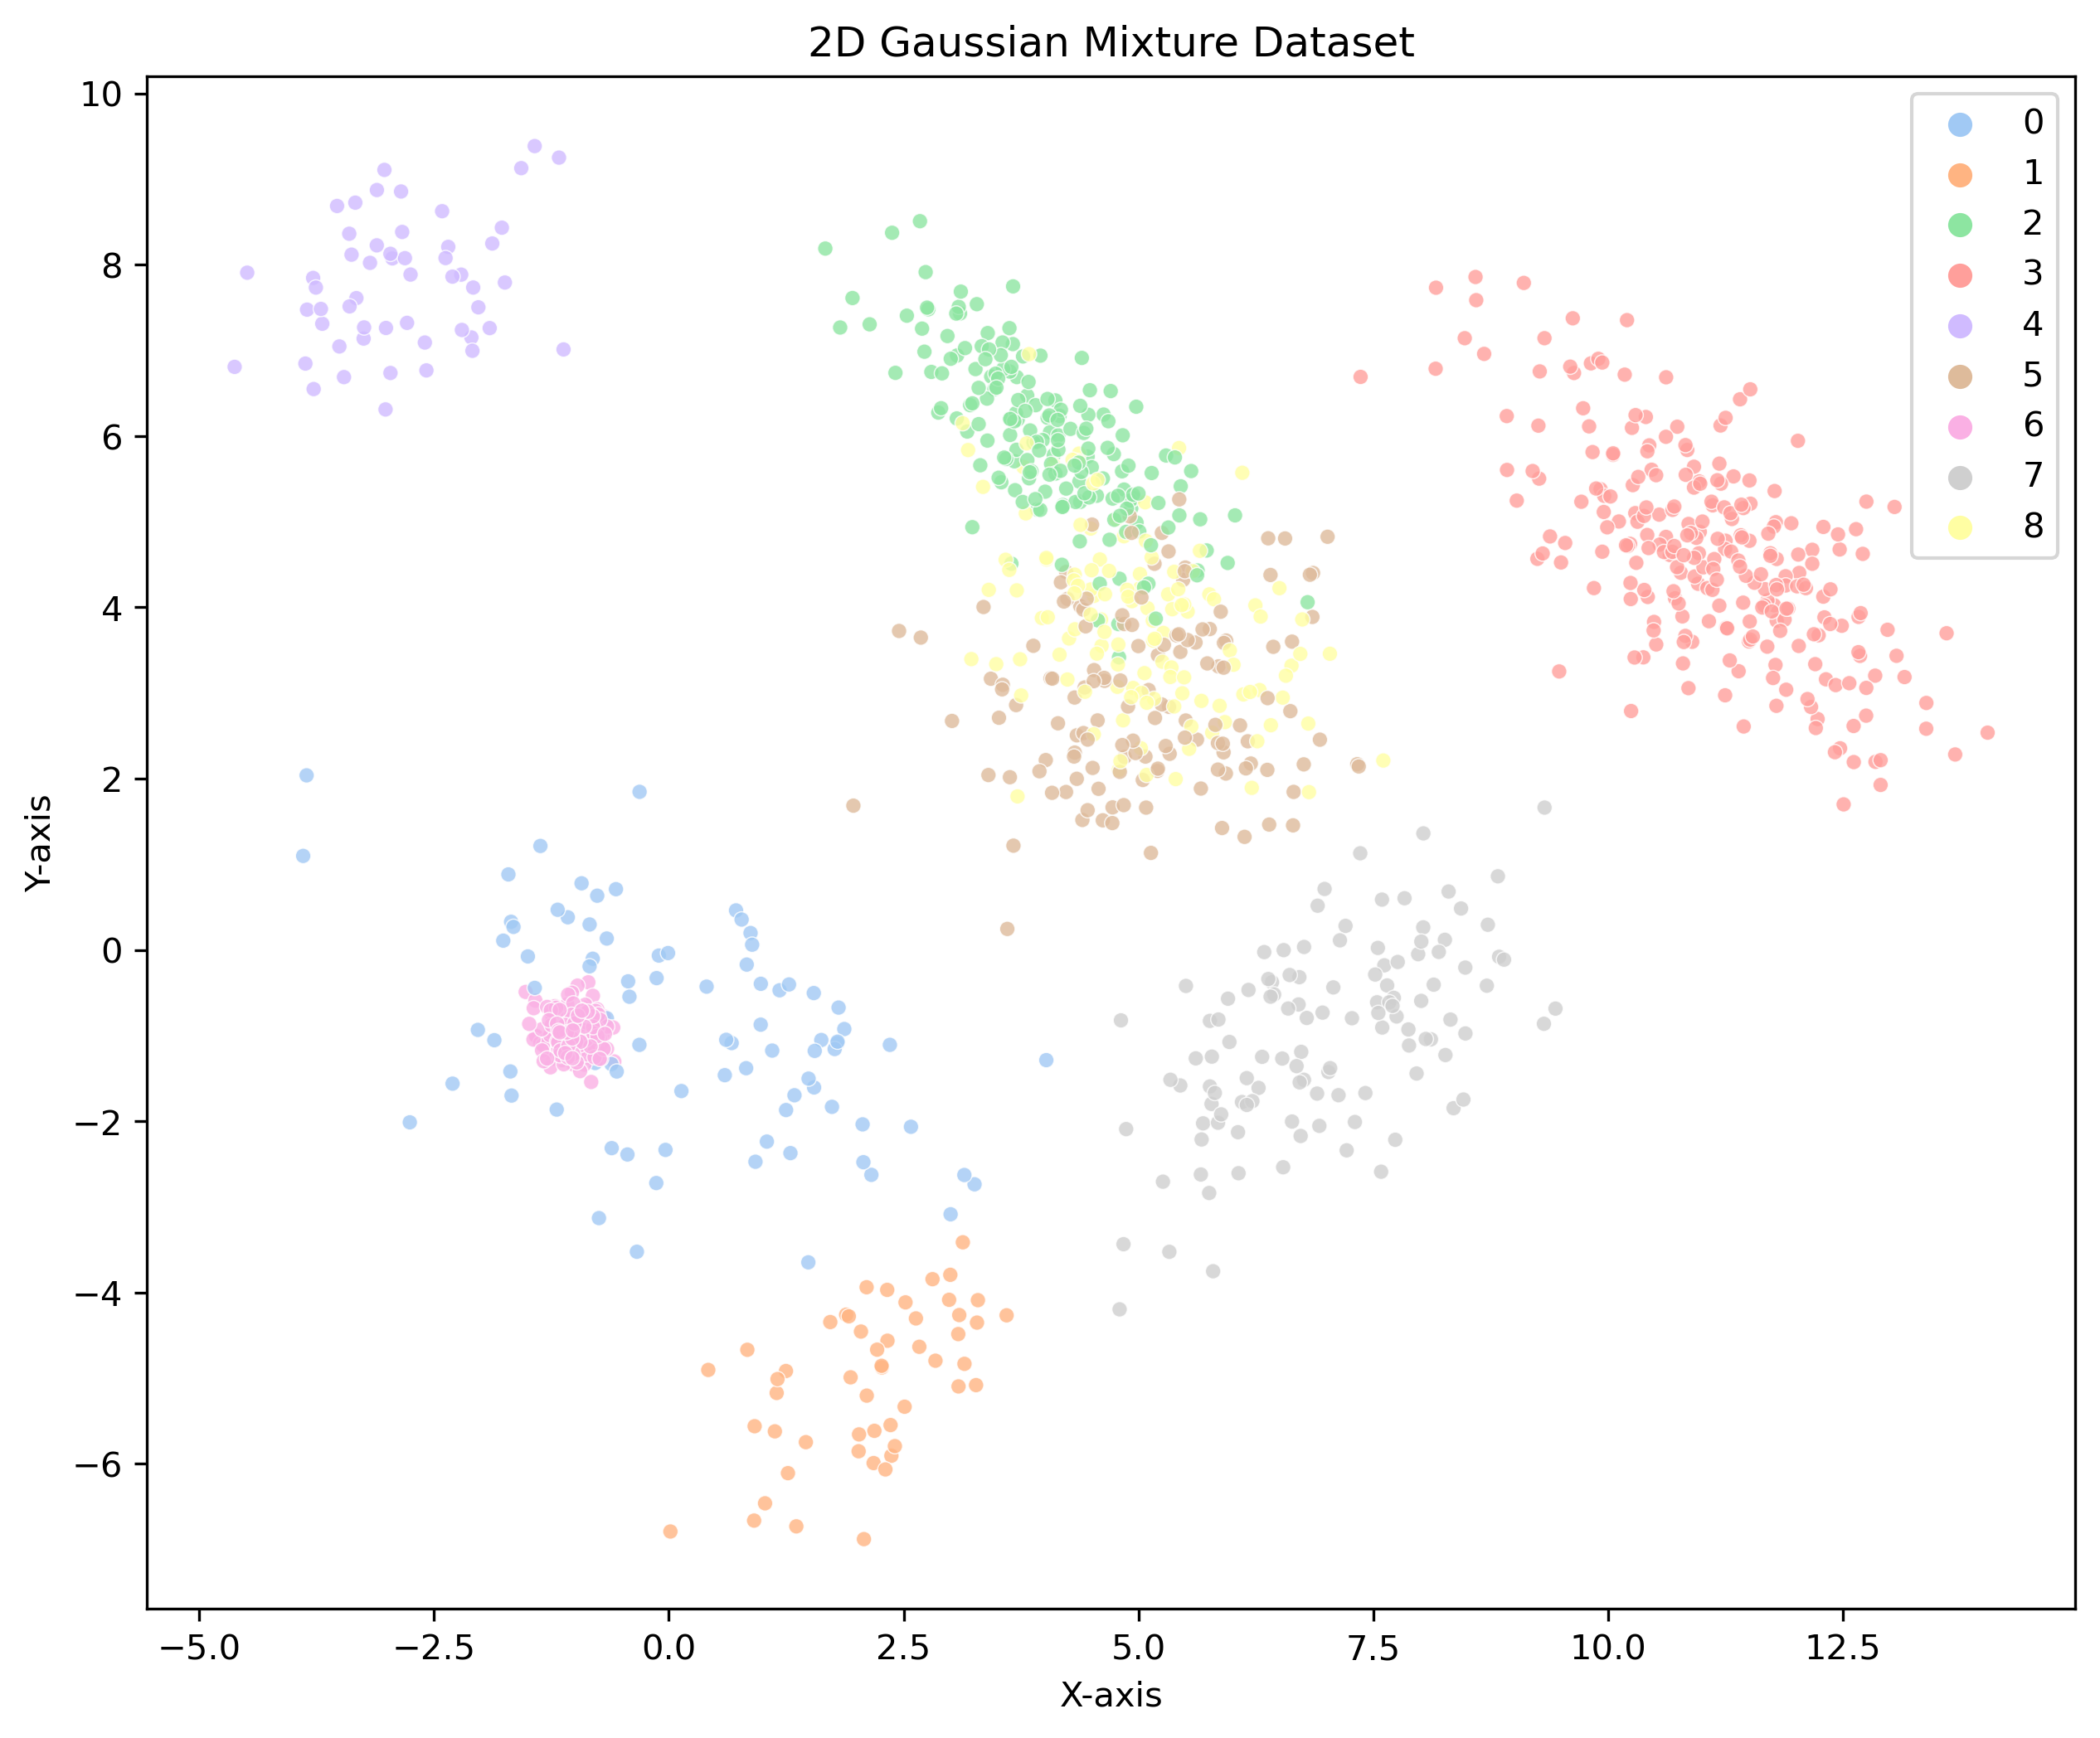

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))

# Generate data points from the 2D Gaussian mixture

custom_palette = sns.color_palette("pastel", len(np.unique(labels)))

# Visualize the generated data
sns.scatterplot(x=data[:, 0], y=data[:, 1], alpha=0.8, hue=labels, ax=ax, palette=custom_palette, s=20)


ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('2D Gaussian Mixture Dataset');

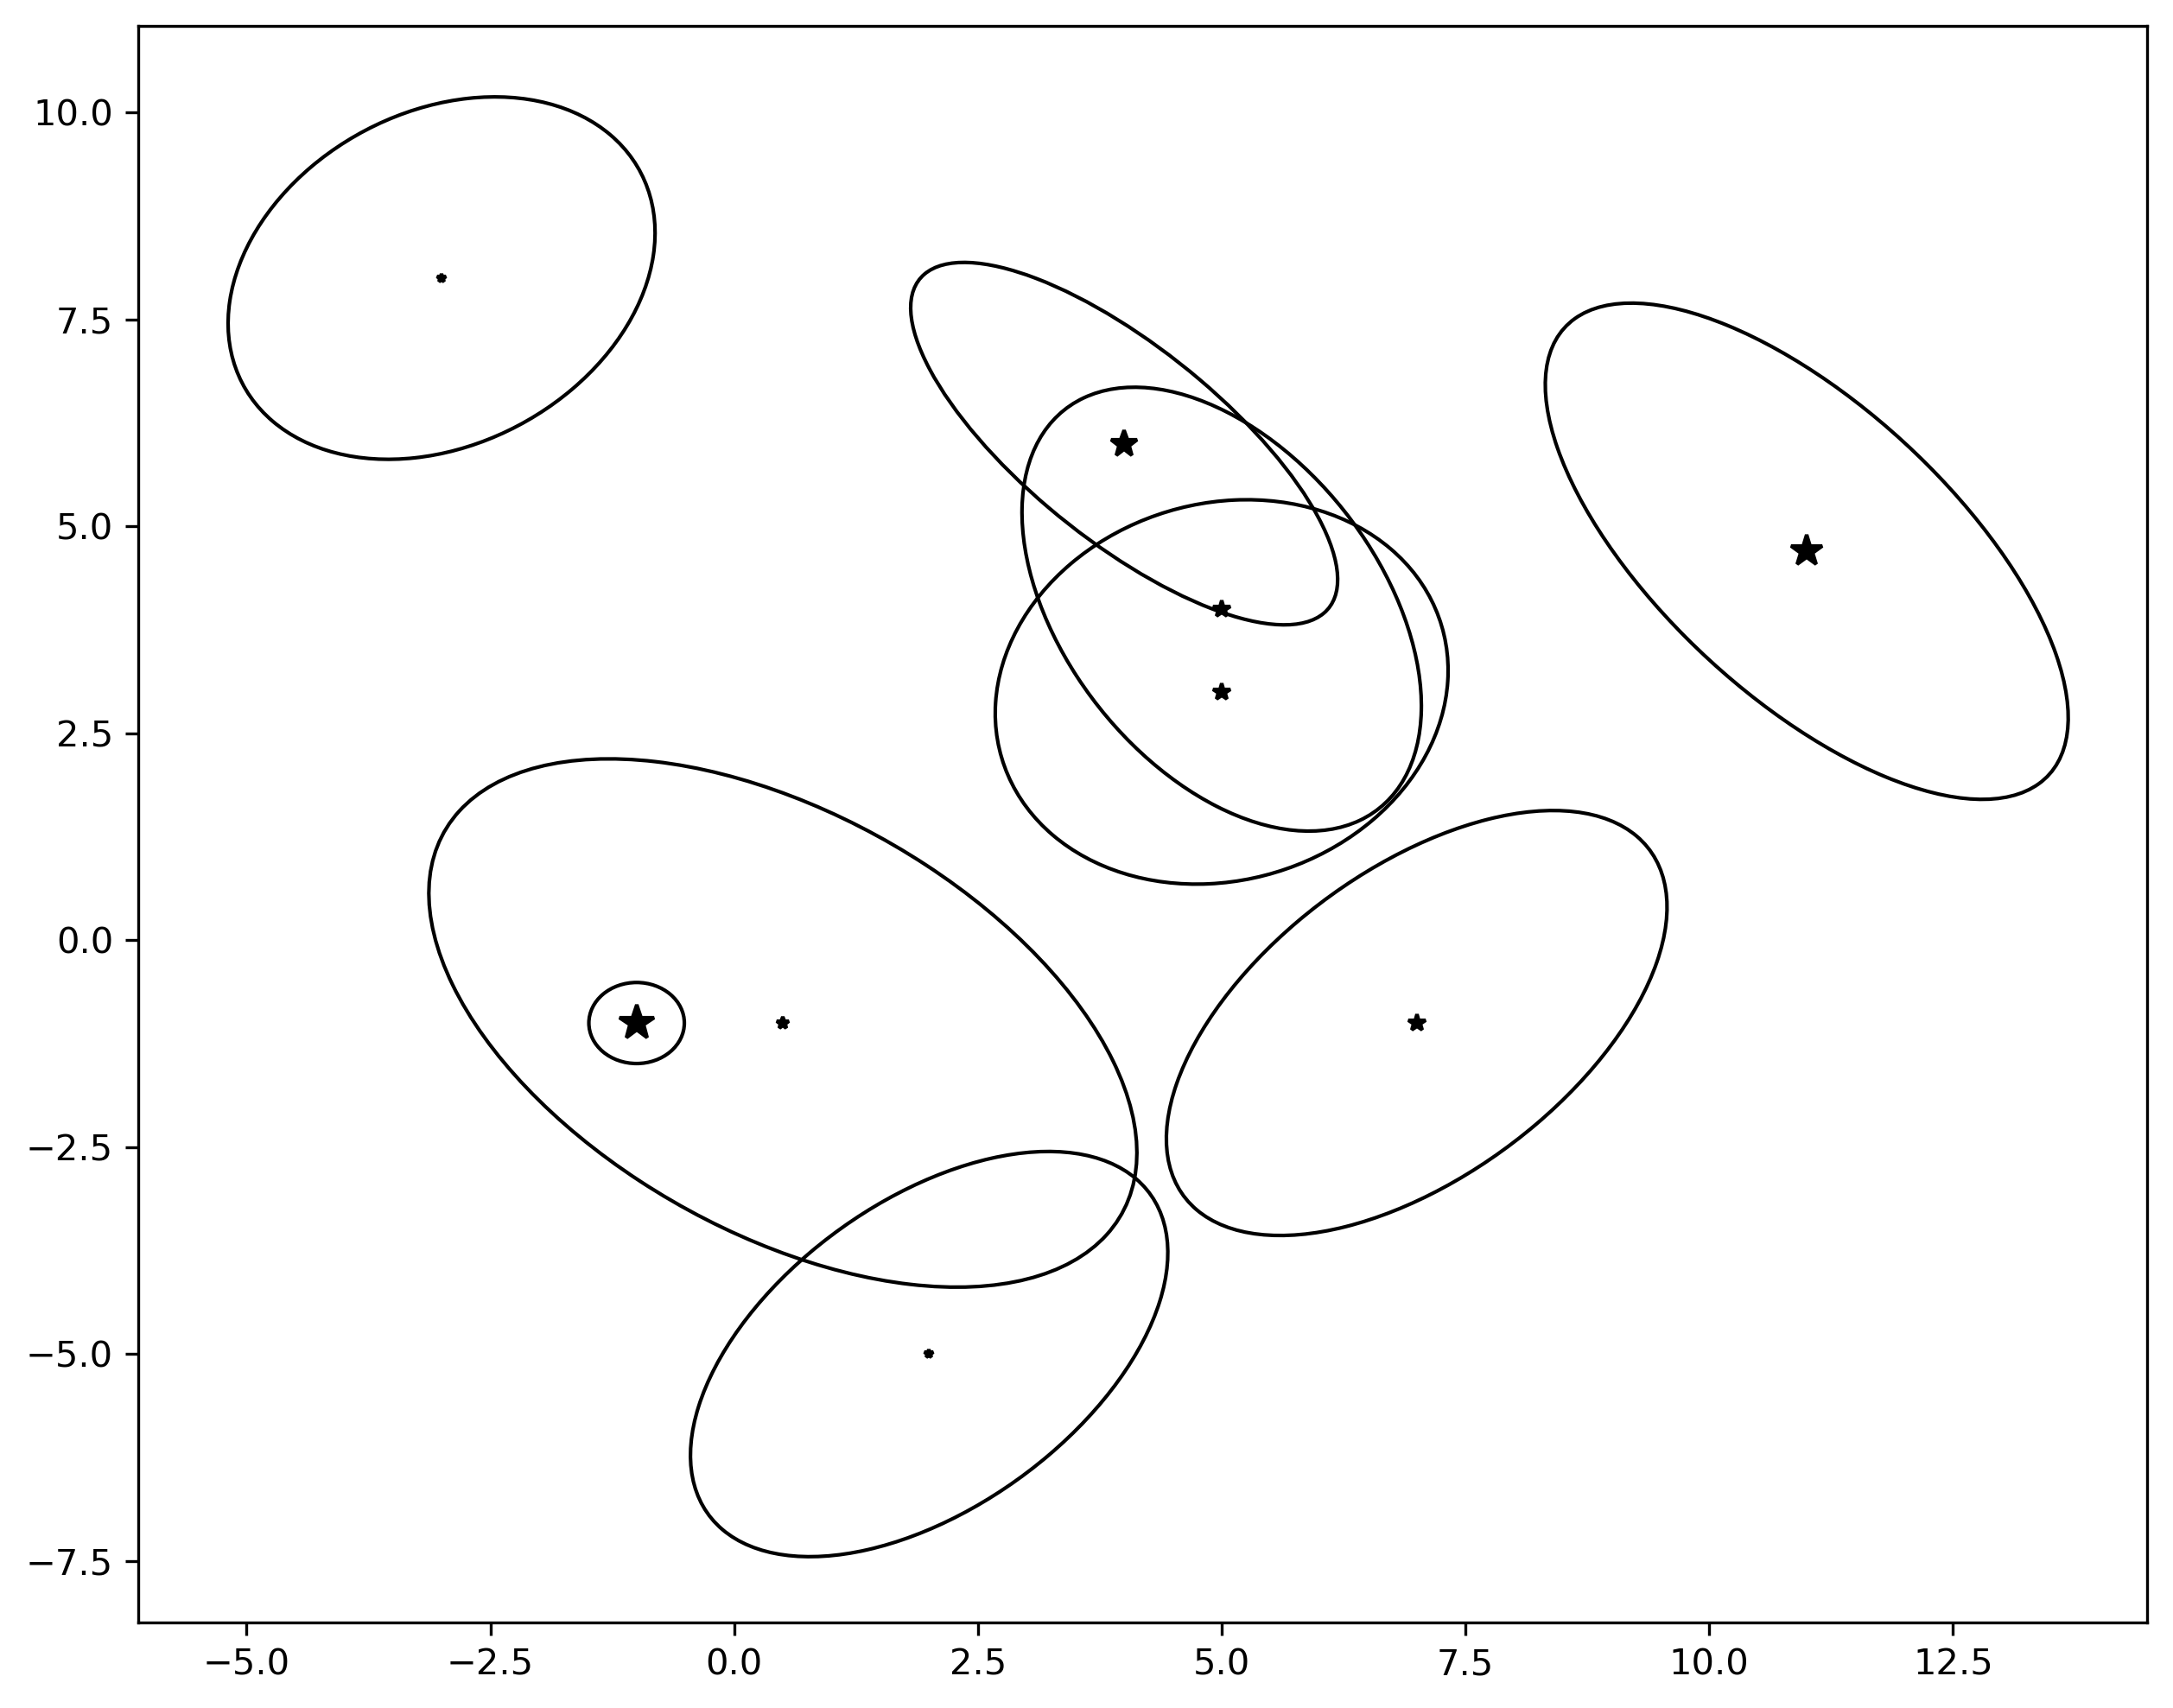

In [21]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(figsize=(10, 8))
neuron_params = []
for weight, mean, cov in zip(probabilities, means, covariances):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * np.sqrt(5.991 * eigenvalues)
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color='black', fill=False)
    ax.add_patch(ell)
    ax.plot(mean[0], mean[1], color='black', markersize=50*weight, marker='*')[0]


In [22]:
labels[labels==5] = 2
labels[labels==8] = 2

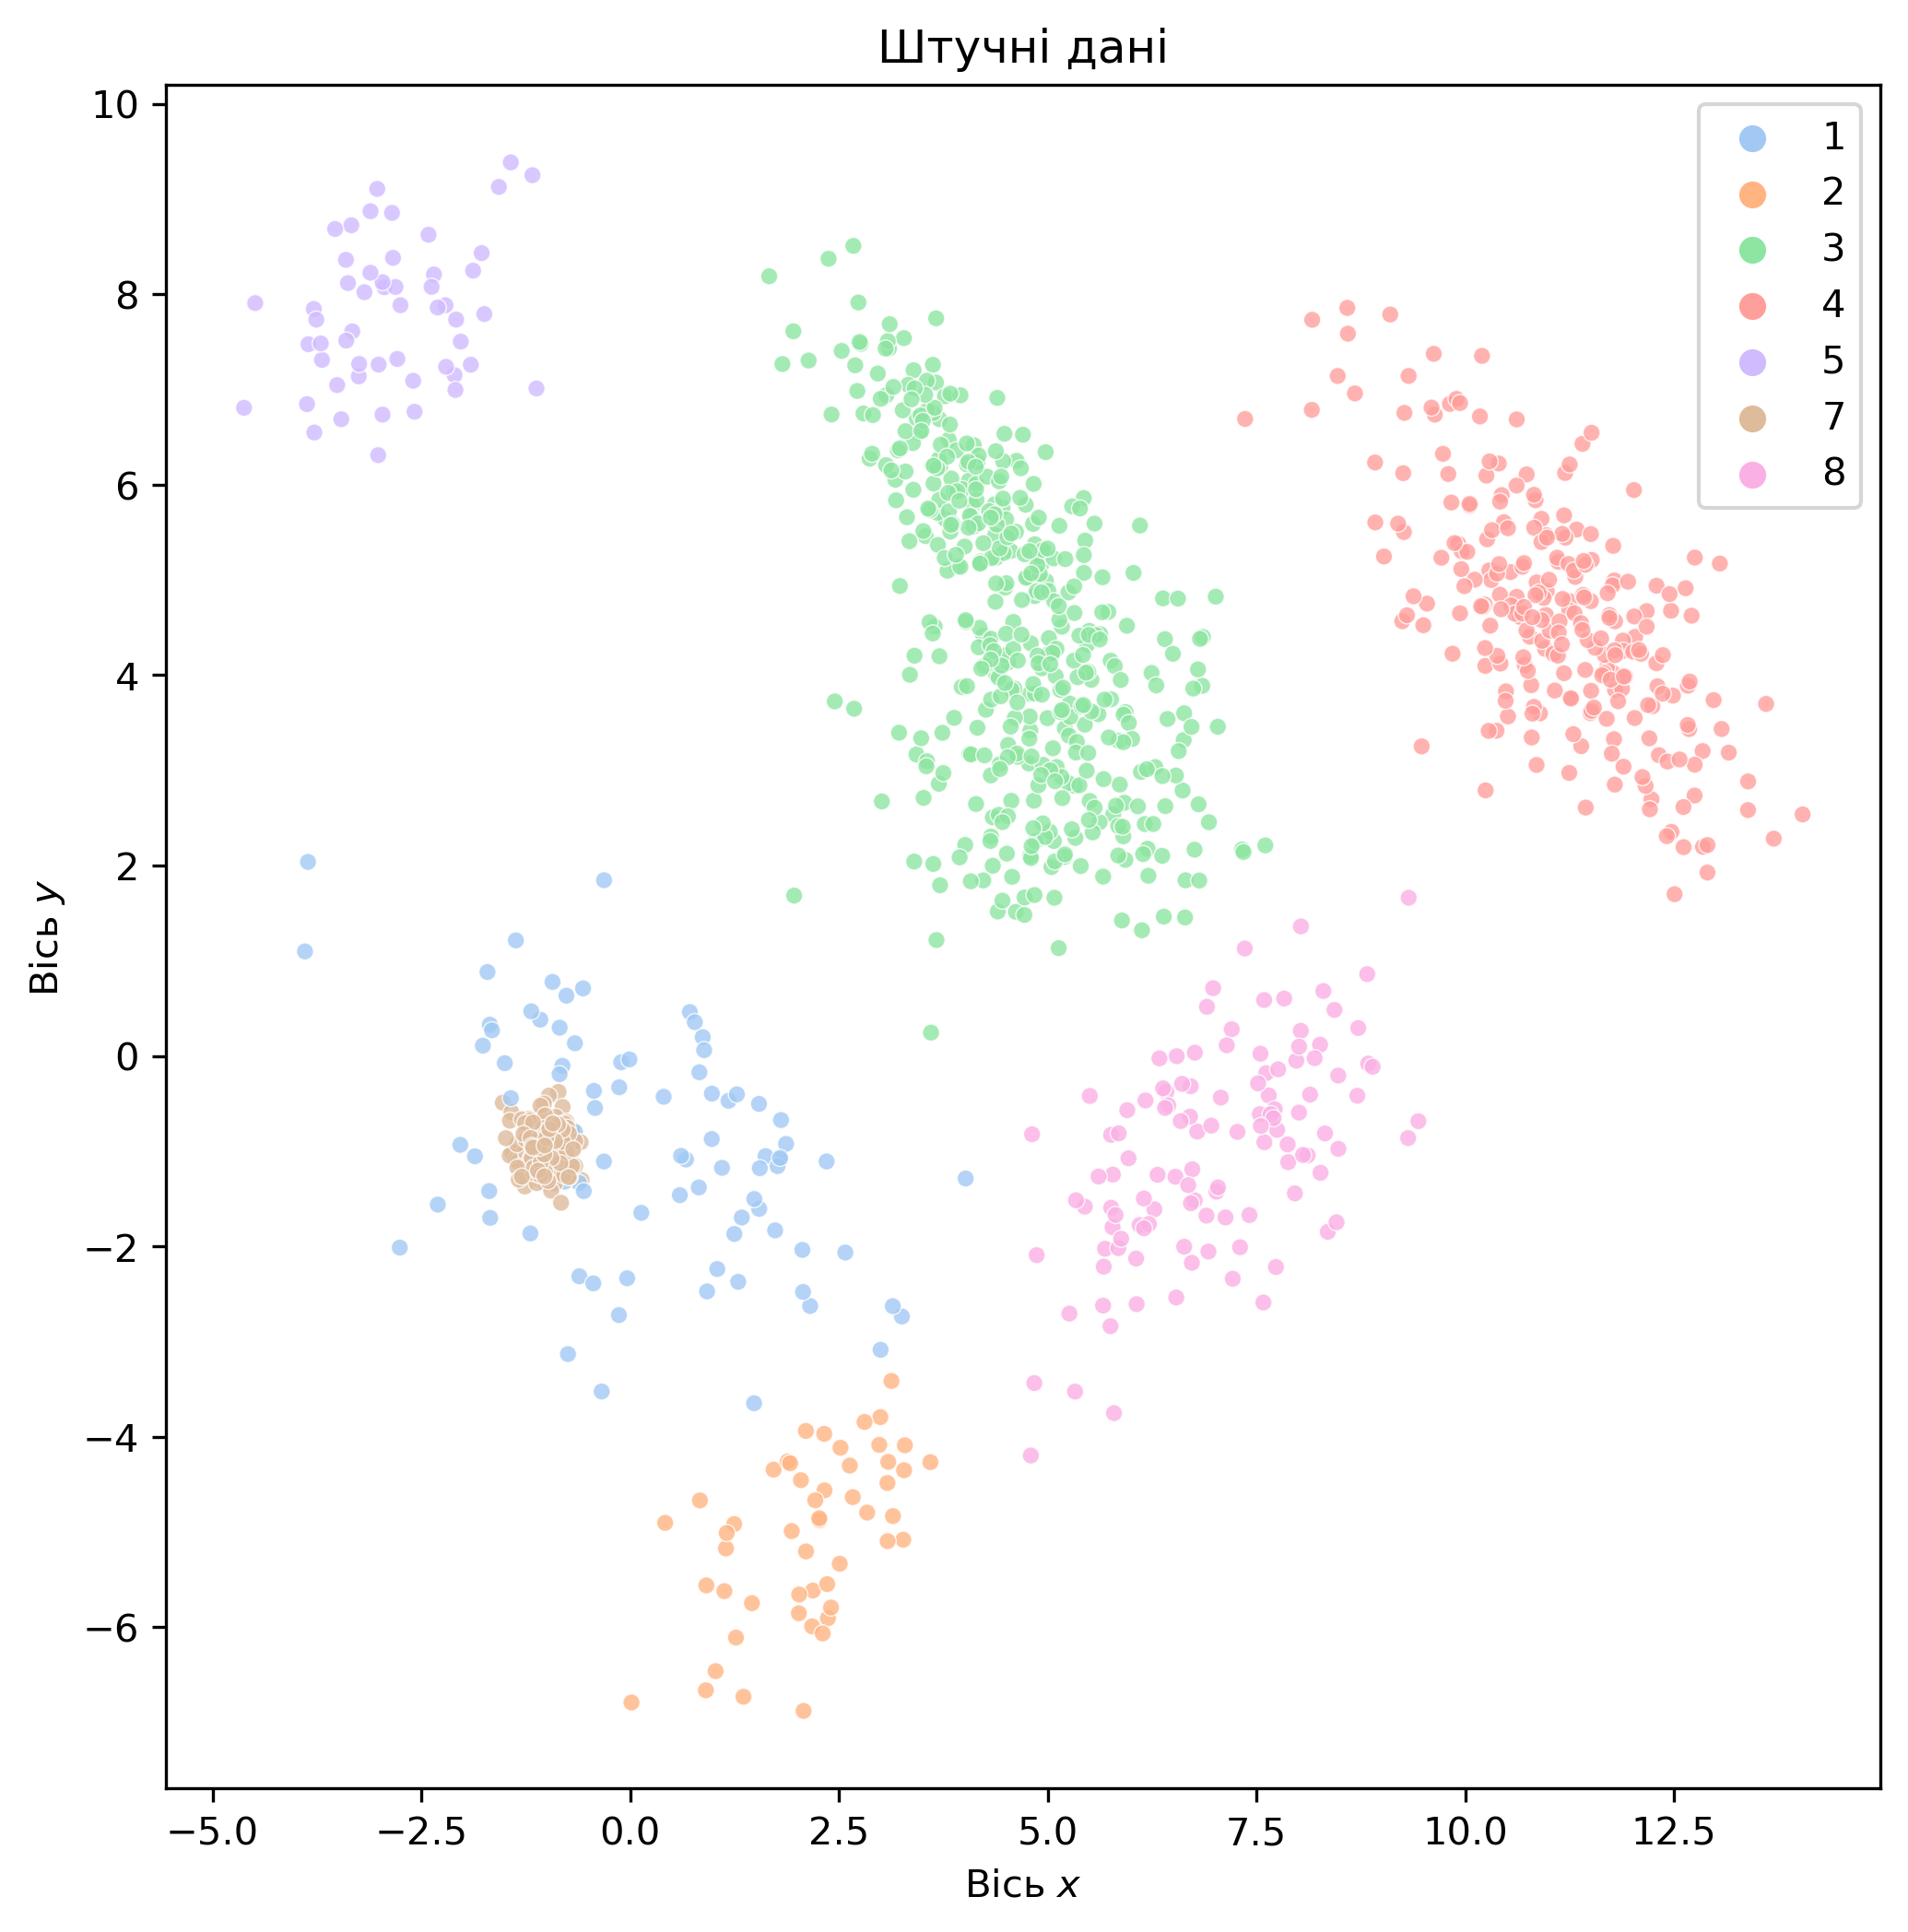

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))

# Generate data points from the 2D Gaussian mixture

custom_palette = sns.color_palette("pastel", len(np.unique(labels)))

# Visualize the generated data
sns.scatterplot(x=data[:, 0], y=data[:, 1], alpha=0.8, hue=labels+1, ax=ax, palette=custom_palette, s=20)

# for mean, color in zip(means, custom_palette):
#     ax.plot(mean[0], mean[1], color=color, markersize=14, marker='*')


ax.set_xlabel('Вісь $x$')
ax.set_ylabel('Вісь $y$')
ax.set_title('Штучні дані')
plt.savefig('../Images/artificial_data.png', dpi=300)

In [24]:
# k*k - max number of clusters
k = 6

### Entropy

In [30]:
lattice = RectangularLattice((k, k))
algorithm1_entropy = Algorithm1(lattice, sigma_start = 0.8, sigma_step = 0.02, max_iter=100, tol=1e-5, 
                            betta=0.3, cov_type='spherical', reg_covar=1e-4, merge_method='entropy', merge_threshold=None)
algorithm1_entropy.fit(data)

<Axes: >

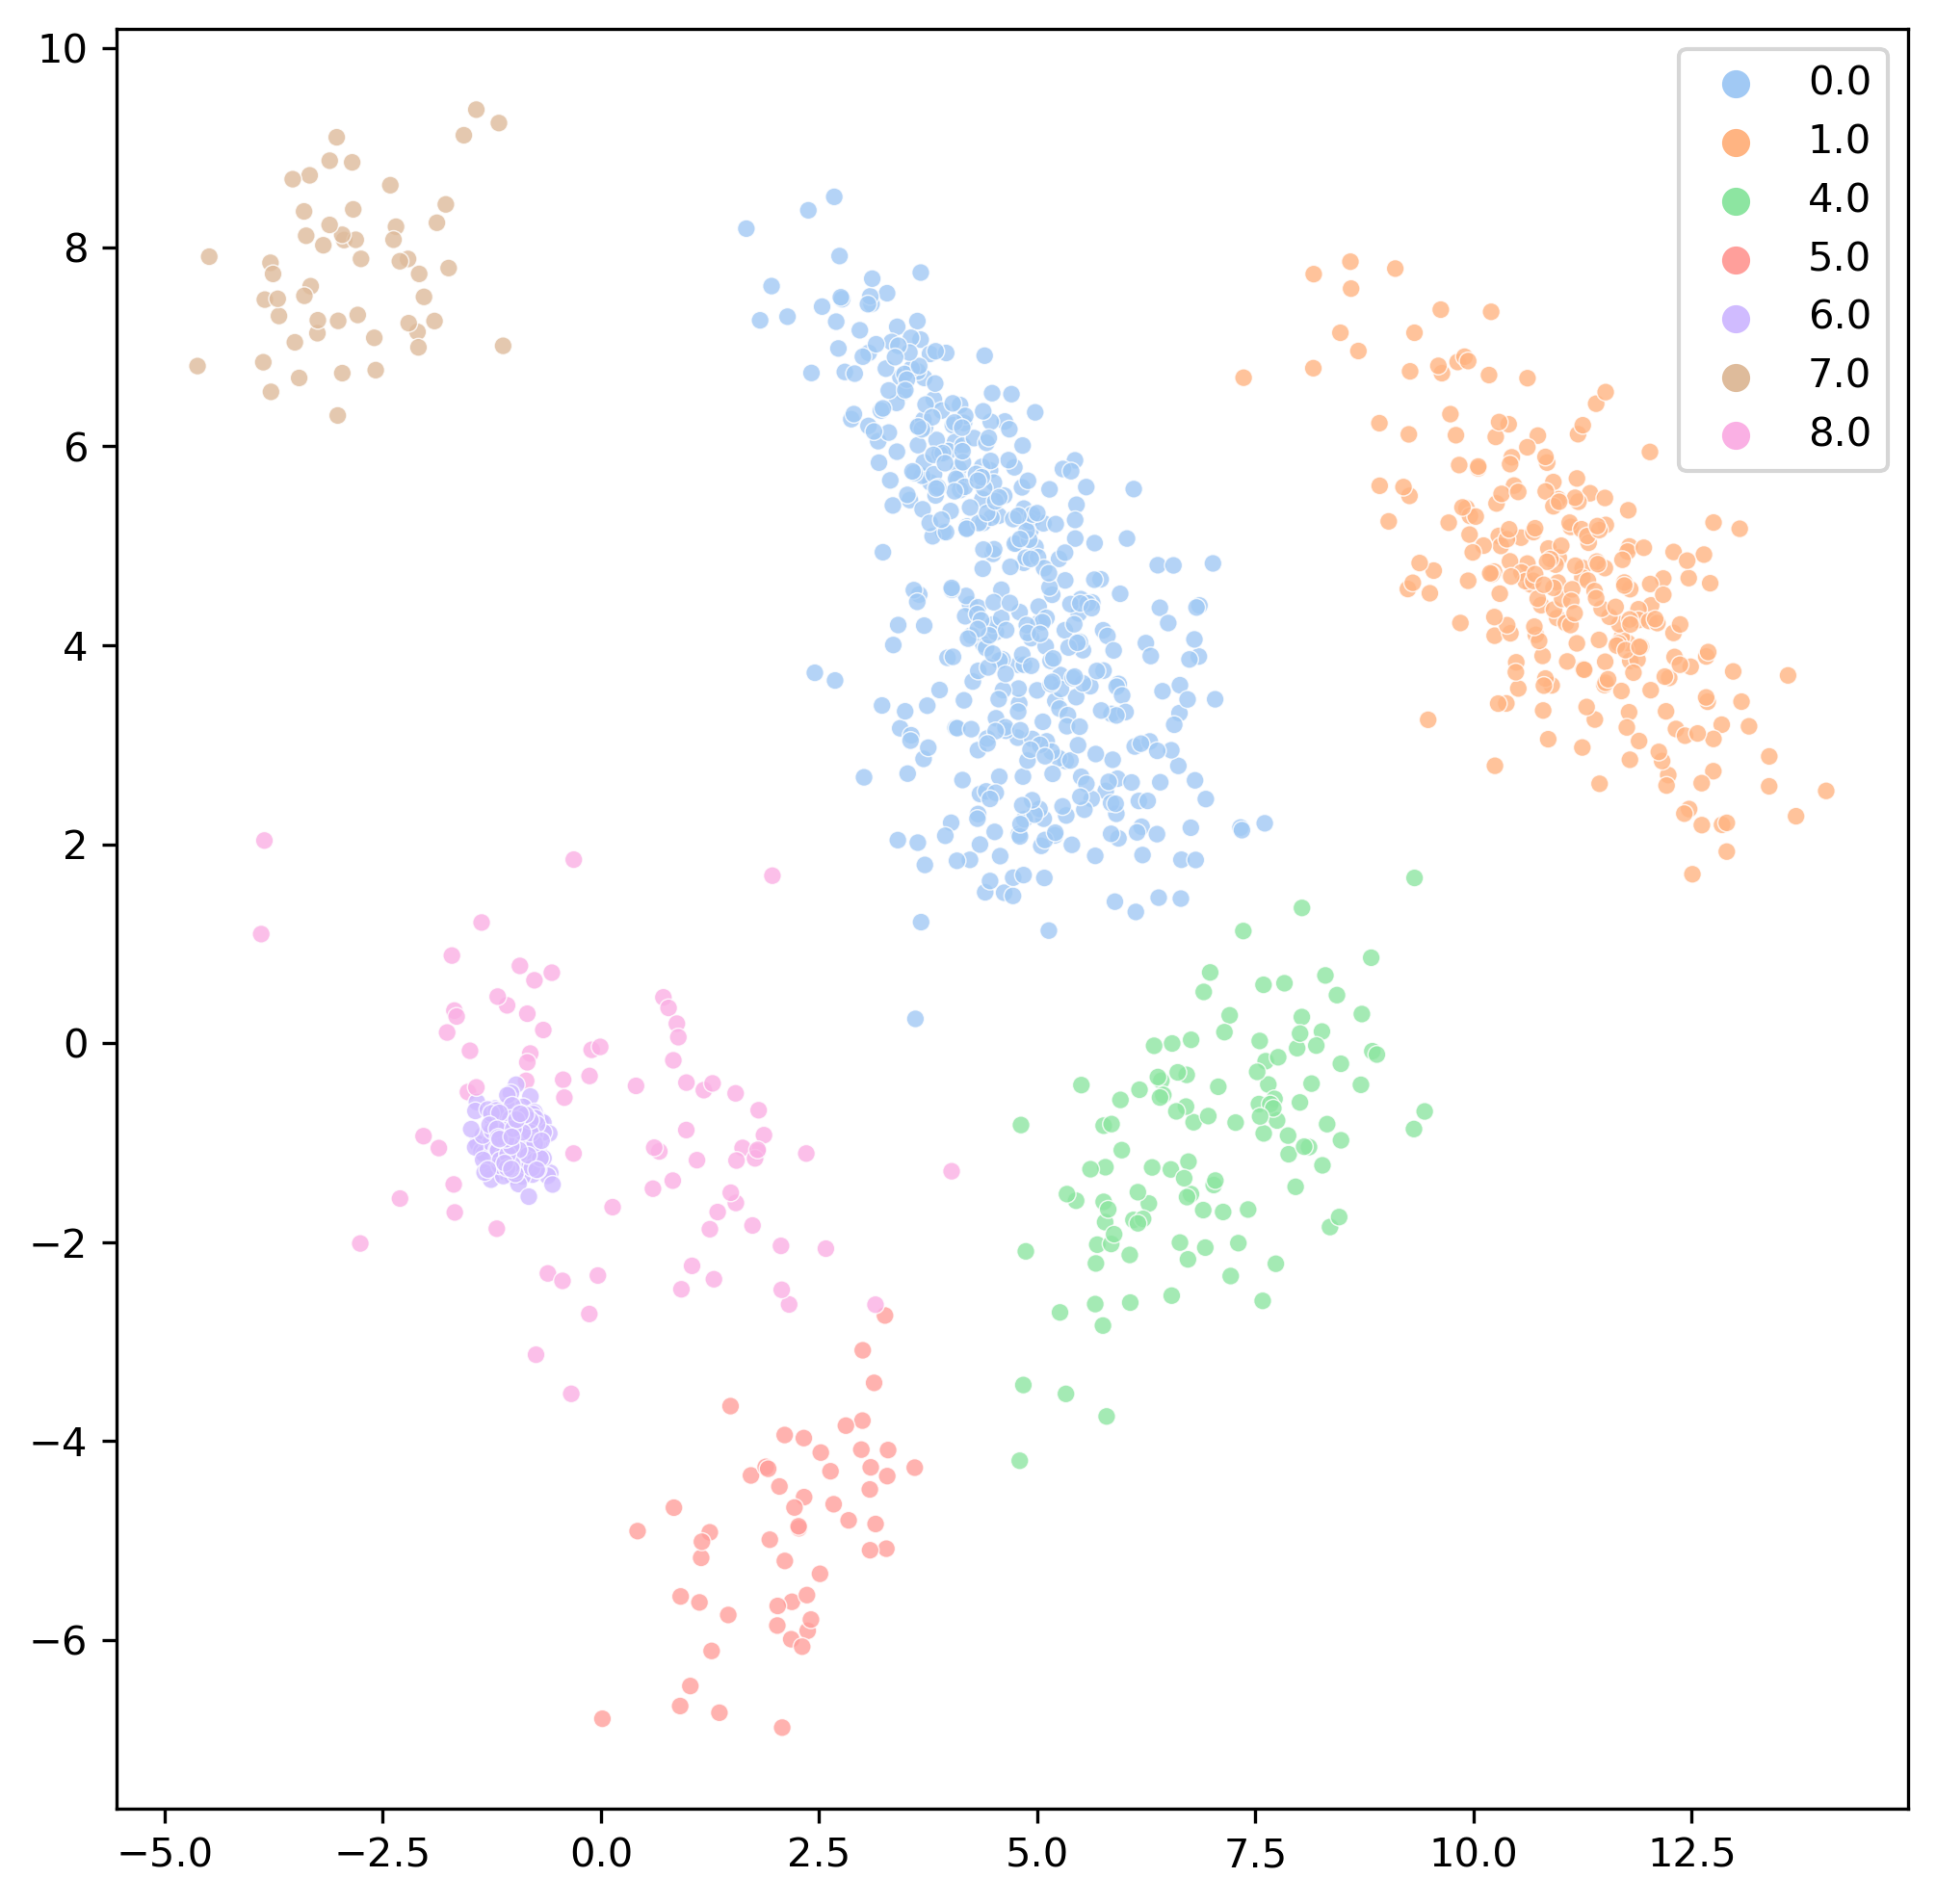

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=data[:, 0], y=data[:, 1], alpha=0.8, hue=algorithm1_entropy.labels_, ax=ax, palette='pastel', s=20)

In [14]:
statistics = []

for i in range(epochs):
    lattice = RectangularLattice((k, k))

    algorithm1_entropy = Algorithm1(lattice, sigma_start = 0.8, sigma_step = 0.02, max_iter=100, tol=1e-5, 
                            betta=0.3, cov_type='spherical', reg_covar=1e-4, merge_method='entropy', merge_threshold=None)

    algorithm1_entropy.fit(data)
    statistics.append([clustering_quality(labels, algorithm1_entropy.labels_)])

    print("Epoch {} done".format(i))

Adjusted Rand Index: 0.9104707273096246
Normalized Mutual Information: 0.9295137395807158
Adjusted Mutual Information: 0.9289538175153285
V-Measure: 0.9295137395807158
Fowlkes-Mallows Score: 0.932786709532793
Epoch 0 done
Adjusted Rand Index: 0.9844721559475202
Normalized Mutual Information: 0.9668836402633946
Adjusted Mutual Information: 0.9665816597276512
V-Measure: 0.9668836402633947
Fowlkes-Mallows Score: 0.9878233942097486
Epoch 1 done
Adjusted Rand Index: 0.88933913905749
Normalized Mutual Information: 0.9175947184700646
Adjusted Mutual Information: 0.9168071870493049
V-Measure: 0.9175947184700645
Fowlkes-Mallows Score: 0.9152526817775426
Epoch 2 done
Adjusted Rand Index: 0.983323349188112
Normalized Mutual Information: 0.9644097794841198
Adjusted Mutual Information: 0.9640851651289618
V-Measure: 0.9644097794841198
Fowlkes-Mallows Score: 0.9869230343579097
Epoch 3 done
Adjusted Rand Index: 0.9104707273096246
Normalized Mutual Information: 0.9295137395807158
Adjusted Mutual Inform

In [15]:
entropy_statistics = np.array(statistics)
entropy_statistics = entropy_statistics.transpose(2, 1, 0).squeeze()

In [16]:
entropy_statistics[0]

array([0.91047073, 0.98447216, 0.88933914, 0.98332335, 0.91047073,
       0.91047073, 0.90763455, 0.91047073, 0.90763455, 0.91047073,
       0.88647432, 0.9090477 , 0.91190363, 0.98447216, 0.9090477 ,
       0.98447216, 0.98447216, 0.9090477 , 0.98447216, 0.98447216,
       0.9090477 , 0.98447216, 0.91047073, 0.9090477 , 0.88647432,
       0.9090477 , 0.91047073, 0.98332335, 0.90763455, 0.91190363,
       0.98106917, 0.98221699, 0.91190363, 0.98389358, 0.90763455,
       0.91190363, 0.88620197, 0.98221699, 0.91190363, 0.98447216,
       0.91047073, 0.90763455, 0.91190363, 0.91190363, 0.91190363,
       0.9090477 , 0.98332335, 0.9090477 , 0.90763455, 0.98447216,
       0.91047073, 0.98447216, 0.91190363, 0.91190363, 0.91047073,
       0.91190363, 0.88647432, 0.90763455, 0.91190363, 0.91047073,
       0.98447216, 0.9090477 , 0.91190363, 0.98332335, 0.9090477 ,
       0.91190363, 0.9090477 , 0.98447216, 0.9090477 , 0.91047073,
       0.91047073, 0.91190363, 0.91047073, 0.98447216, 0.91190

In [17]:
np.mean(entropy_statistics[0])

0.9287249425428551

### Ridgeline

In [40]:
lattice = RectangularLattice((k, k))
algorithm1_ridgeline = Algorithm1(lattice, sigma_start = 0.8, sigma_step = 0.02, max_iter=100, tol=1e-5, 
                            betta=0.3, cov_type='spherical', reg_covar=1e-4, merge_method='ridgeline', merge_threshold=0.8)

algorithm1_ridgeline.fit(data)

<Axes: >

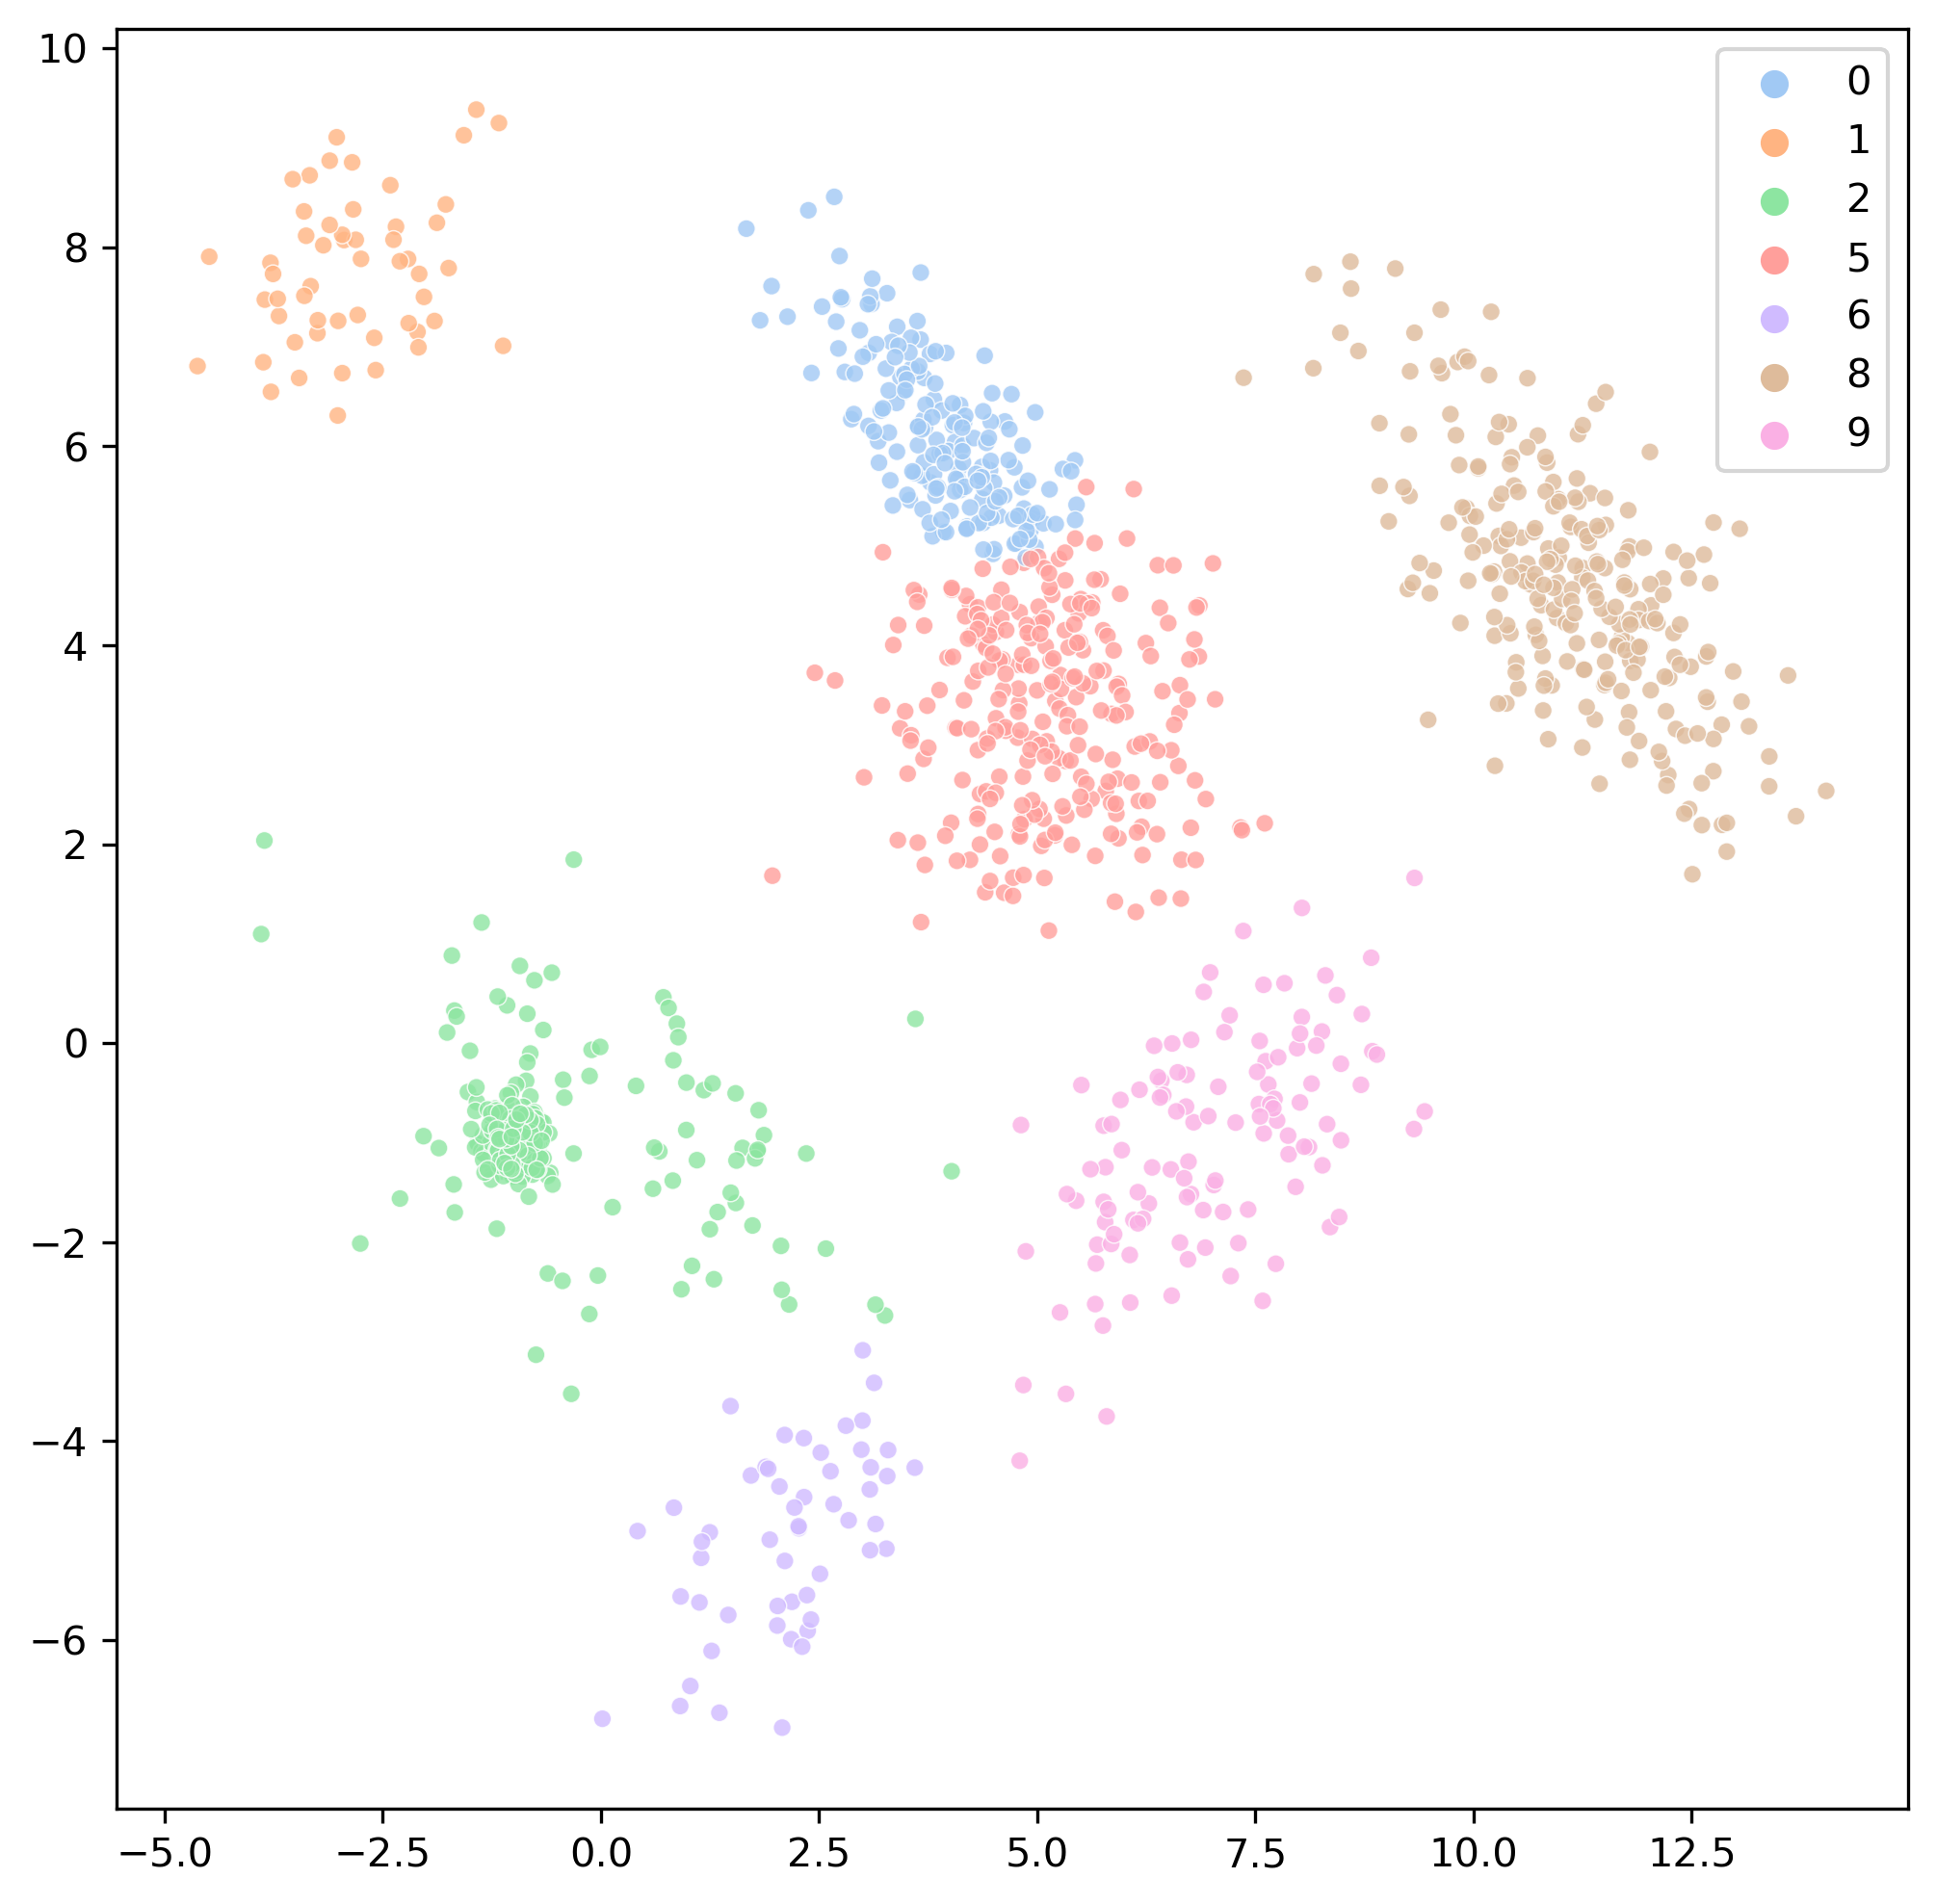

In [41]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=data[:, 0], y=data[:, 1], alpha=0.8, hue=algorithm1_ridgeline.labels_, ax=ax, palette='pastel', s=20)

In [18]:
statistics = []

for i in range(epochs):
    lattice = RectangularLattice((k, k))

    algorithm1_ridgeline = Algorithm1(lattice, sigma_start = 0.8, sigma_step = 0.02, max_iter=100, tol=1e-5, 
                            betta=0.3, cov_type='spherical', reg_covar=1e-4, merge_method='ridgeline', merge_threshold=0.2)

    algorithm1_ridgeline.fit(data)
    statistics.append([clustering_quality(labels, algorithm1_ridgeline.labels_)])

    print("Epoch {} done".format(i))

Adjusted Rand Index: 0.9097969995067127
Normalized Mutual Information: 0.9279140329802803
Adjusted Mutual Information: 0.9273415338652231
V-Measure: 0.9279140329802803
Fowlkes-Mallows Score: 0.9322758837782091
Epoch 0 done
Adjusted Rand Index: 0.9119036272620001
Normalized Mutual Information: 0.9312183564827162
Adjusted Mutual Information: 0.9306722835873188
V-Measure: 0.9312183564827163
Fowlkes-Mallows Score: 0.9338381207043288
Epoch 1 done
Adjusted Rand Index: 0.9133463968566967
Normalized Mutual Information: 0.9330268611721472
Adjusted Mutual Information: 0.9324954411684931
V-Measure: 0.9330268611721472
Fowlkes-Mallows Score: 0.9348983491997767
Epoch 2 done
Adjusted Rand Index: 0.9104707273096246
Normalized Mutual Information: 0.9295137395807158
Adjusted Mutual Information: 0.9289538175153285
V-Measure: 0.9295137395807158
Fowlkes-Mallows Score: 0.932786709532793
Epoch 3 done
Adjusted Rand Index: 0.9119036272620001
Normalized Mutual Information: 0.9312183564827162
Adjusted Mutual Inf

In [19]:
ridgeline_statistics = np.array(statistics)
ridgeline_statistics = ridgeline_statistics.transpose(2, 1, 0).squeeze()

In [20]:
ridgeline_statistics[0]

array([0.909797  , 0.91190363, 0.9133464 , 0.91047073, 0.91190363,
       0.91047073, 0.90763455, 0.91047073, 0.9090477 , 0.91190363,
       0.90836625, 0.9090477 , 0.91190363, 0.91190363, 0.9090477 ,
       0.91190363, 0.9090477 , 0.91190363, 0.91047073, 0.91047073,
       0.91047073, 0.909797  , 0.909797  , 0.91190363, 0.90763455,
       0.91190363, 0.9090477 , 0.91190363, 0.91047073, 0.91190363,
       0.90763455, 0.9090477 , 0.91190363, 0.9090477 , 0.9090477 ,
       0.909797  , 0.90763455, 0.90763455, 0.91047073, 0.909797  ,
       0.91190363, 0.91190363, 0.91190363, 0.91047073, 0.91190363,
       0.91190363, 0.9090477 , 0.90755455, 0.9090477 , 0.91047073,
       0.909797  , 0.9090477 , 0.91047073, 0.91190363, 0.909797  ,
       0.9133464 , 0.909797  , 0.91190363, 0.91190363, 0.91190363,
       0.9090477 , 0.9090477 , 0.9090477 , 0.909797  , 0.91190363,
       0.9090477 , 0.9090477 , 0.9090477 , 0.91047073, 0.91190363,
       0.91190363, 0.91190363, 0.90755455, 0.9133464 , 0.91047

In [21]:
np.mean(ridgeline_statistics[0])

0.9103725104211223

### GMM + Entropy

In [22]:
gmm_entropy = Algorithm2(2, k*k)
gmm_entropy.fit(data)

statistics = []

for i in range(epochs):
    gmm_entropy = Algorithm2(2, k*k)
    gmm_entropy.fit(data)
    statistics.append([clustering_quality(labels, gmm_entropy.labels_)])

    print("Epoch {} done".format(i))

Best K:7, BIC:10738.51961724834
Best K:8, BIC:10715.529790551547
Adjusted Rand Index: 0.9119036272620001
Normalized Mutual Information: 0.9312183564827162
Adjusted Mutual Information: 0.9306722835873188
V-Measure: 0.9312183564827163
Fowlkes-Mallows Score: 0.9338381207043288
Epoch 0 done
Best K:7, BIC:10722.35583567486
Adjusted Rand Index: 0.9642783691670007
Normalized Mutual Information: 0.9490210991487921
Adjusted Mutual Information: 0.9486265299999176
V-Measure: 0.9490210991487921
Fowlkes-Mallows Score: 0.9723124254373893
Epoch 1 done
Best K:7, BIC:10726.582292367508
Adjusted Rand Index: 0.9642783691670007
Normalized Mutual Information: 0.9490210991487921
Adjusted Mutual Information: 0.9486265299999176
V-Measure: 0.9490210991487921
Fowlkes-Mallows Score: 0.9723124254373893
Epoch 2 done
Best K:8, BIC:10691.135386015285
Adjusted Rand Index: 0.9119036272620001
Normalized Mutual Information: 0.9312183564827162
Adjusted Mutual Information: 0.9306722835873188
V-Measure: 0.9312183564827163


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Best K:9, BIC:10749.860649372135
Adjusted Rand Index: 0.9119036272620001
Normalized Mutual Information: 0.9312183564827163
Adjusted Mutual Information: 0.930672283587319
V-Measure: 0.9312183564827162
Fowlkes-Mallows Score: 0.9338381207043288
Epoch 35 done
Best K:10, BIC:10715.804885933007
Adjusted Rand Index: 0.9844721559475202
Normalized Mutual Information: 0.9668836402633946
Adjusted Mutual Information: 0.9665816597276512
V-Measure: 0.9668836402633947
Fowlkes-Mallows Score: 0.9878233942097486
Epoch 36 done
Best K:8, BIC:10749.17924472448
Adjusted Rand Index: 0.9090476994027141
Normalized Mutual Information: 0.9278958682820523
Adjusted Mutual Information: 0.9273227653671069
V-Measure: 0.9278958682820524
Fowlkes-Mallows Score: 0.9317441233407124
Epoch 37 done
Best K:8, BIC:10719.705129410035
Adjusted Rand Index: 0.9119036272620001
Normalized Mutual Information: 0.9312183564827162
Adjusted Mutual Information: 0.9306722835873188
V-Measure: 0.9312183564827163
Fowlkes-Mallows Score: 0.9338

In [23]:
gmm_entropy_statistics = np.array(statistics)
gmm_entropy_statistics = gmm_entropy_statistics.transpose(2, 1, 0).squeeze()

In [24]:
gmm_entropy_statistics[0]

array([0.91190363, 0.96427837, 0.96427837, 0.91190363, 0.96427837,
       0.96427837, 0.91190363, 0.96427837, 0.96427837, 0.98270569,
       0.98447216, 0.91190363, 0.9090477 , 0.91190363, 0.96427837,
       0.96427837, 0.91046907, 0.96427837, 0.91190363, 0.96427837,
       0.98221699, 0.96427837, 0.96427837, 0.96427837, 0.9090477 ,
       0.91190363, 0.98447216, 0.97845406, 0.91190363, 0.98447216,
       0.98447216, 0.98447216, 0.91190363, 0.96427837, 0.96427837,
       0.91190363, 0.98447216, 0.9090477 , 0.91190363, 0.96427837,
       0.9090477 , 0.9090477 , 0.98447216, 0.91190363, 0.92814855,
       0.96427837, 0.96427837, 0.98447216, 0.91190363, 0.96427837,
       0.98447216, 0.96427837, 0.96427837, 0.96427837, 0.91190363,
       0.91190363, 0.96427837, 0.91190363, 0.96366589, 0.96427837,
       0.98447216, 0.9090477 , 0.96427837, 0.96427837, 0.90763455,
       0.98447216, 0.91190363, 0.91190363, 0.98447216, 0.96427837,
       0.98221699, 0.91190363, 0.96427837, 0.96427837, 0.96427

In [25]:
np.mean(gmm_entropy_statistics[0])

0.9484558397891746

### MML-EM

In [26]:
statistics = []

for i in range(epochs):
    algorithm3 = Algorithm3(kmax=k*k)
    algorithm3.fit(data)
    statistics.append([clustering_quality(labels, algorithm3.labels_)])

    print("Epoch {} done".format(i))

Adjusted Rand Index: 0.7184576584283314
Normalized Mutual Information: 0.8773015691688056
Adjusted Mutual Information: 0.875952403608257
V-Measure: 0.8773015691688055
Fowlkes-Mallows Score: 0.7850031179910913
Epoch 0 done
Adjusted Rand Index: 0.7185125651190304
Normalized Mutual Information: 0.8773044473486803
Adjusted Mutual Information: 0.8759553158581034
V-Measure: 0.8773044473486803
Fowlkes-Mallows Score: 0.7850442128116839
Epoch 1 done
Adjusted Rand Index: 0.7722273741829243
Normalized Mutual Information: 0.9049820556862322
Adjusted Mutual Information: 0.9040415038488763
V-Measure: 0.9049820556862324
Fowlkes-Mallows Score: 0.8253041179781759
Epoch 2 done
Adjusted Rand Index: 0.7185125651190304
Normalized Mutual Information: 0.8773044473486803
Adjusted Mutual Information: 0.8759553158581034
V-Measure: 0.8773044473486803
Fowlkes-Mallows Score: 0.7850442128116839
Epoch 3 done
Adjusted Rand Index: 0.7185125651190304
Normalized Mutual Information: 0.8773044473486803
Adjusted Mutual Inf

In [27]:
mml_em_statistics = np.array(statistics)
mml_em_statistics = mml_em_statistics.transpose(2, 1, 0).squeeze()

In [28]:
mml_em_statistics[0]

array([0.71845766, 0.71851257, 0.77222737, 0.71851257, 0.71851257,
       0.70395832, 0.77293499, 0.70052899, 0.71865531, 0.77241473,
       0.77293499, 0.77249799, 0.71831489, 0.77227942, 0.71932484,
       0.71862237, 0.71833685, 0.71872118, 0.77234188, 0.71872118,
       0.77227942, 0.69155102, 0.77234188, 0.63695128, 0.71828194,
       0.71920414, 0.77241473, 0.62822324, 0.71872118, 0.71884194,
       0.77227942, 0.70065193, 0.77281016, 0.77227942, 0.64043366,
       0.71907244, 0.77227942, 0.77269571, 0.71890781, 0.77234188,
       0.77281016, 0.718238  , 0.71872118, 0.71897366, 0.77234188,
       0.77293499, 0.71884194, 0.67137054, 0.71842471, 0.6340215 ,
       0.77227942, 0.71908342, 0.77234188, 0.71895171, 0.71890781,
       0.77281016, 0.77234188, 0.77269571, 0.71842471, 0.63375944,
       0.77241473, 0.71862237, 0.77281016, 0.71897366, 0.71872118,
       0.6318771 , 0.58774891, 0.64892318, 0.63289538, 0.75465747,
       0.71897366, 0.77227942, 0.71854551, 0.71822702, 0.77281

## Comparison

In [29]:
plt.style.use('seaborn-v0_8-muted')

In [30]:
statistics = np.array([mml_em_statistics[0], entropy_statistics[0], ridgeline_statistics[0], gmm_entropy_statistics[0]])

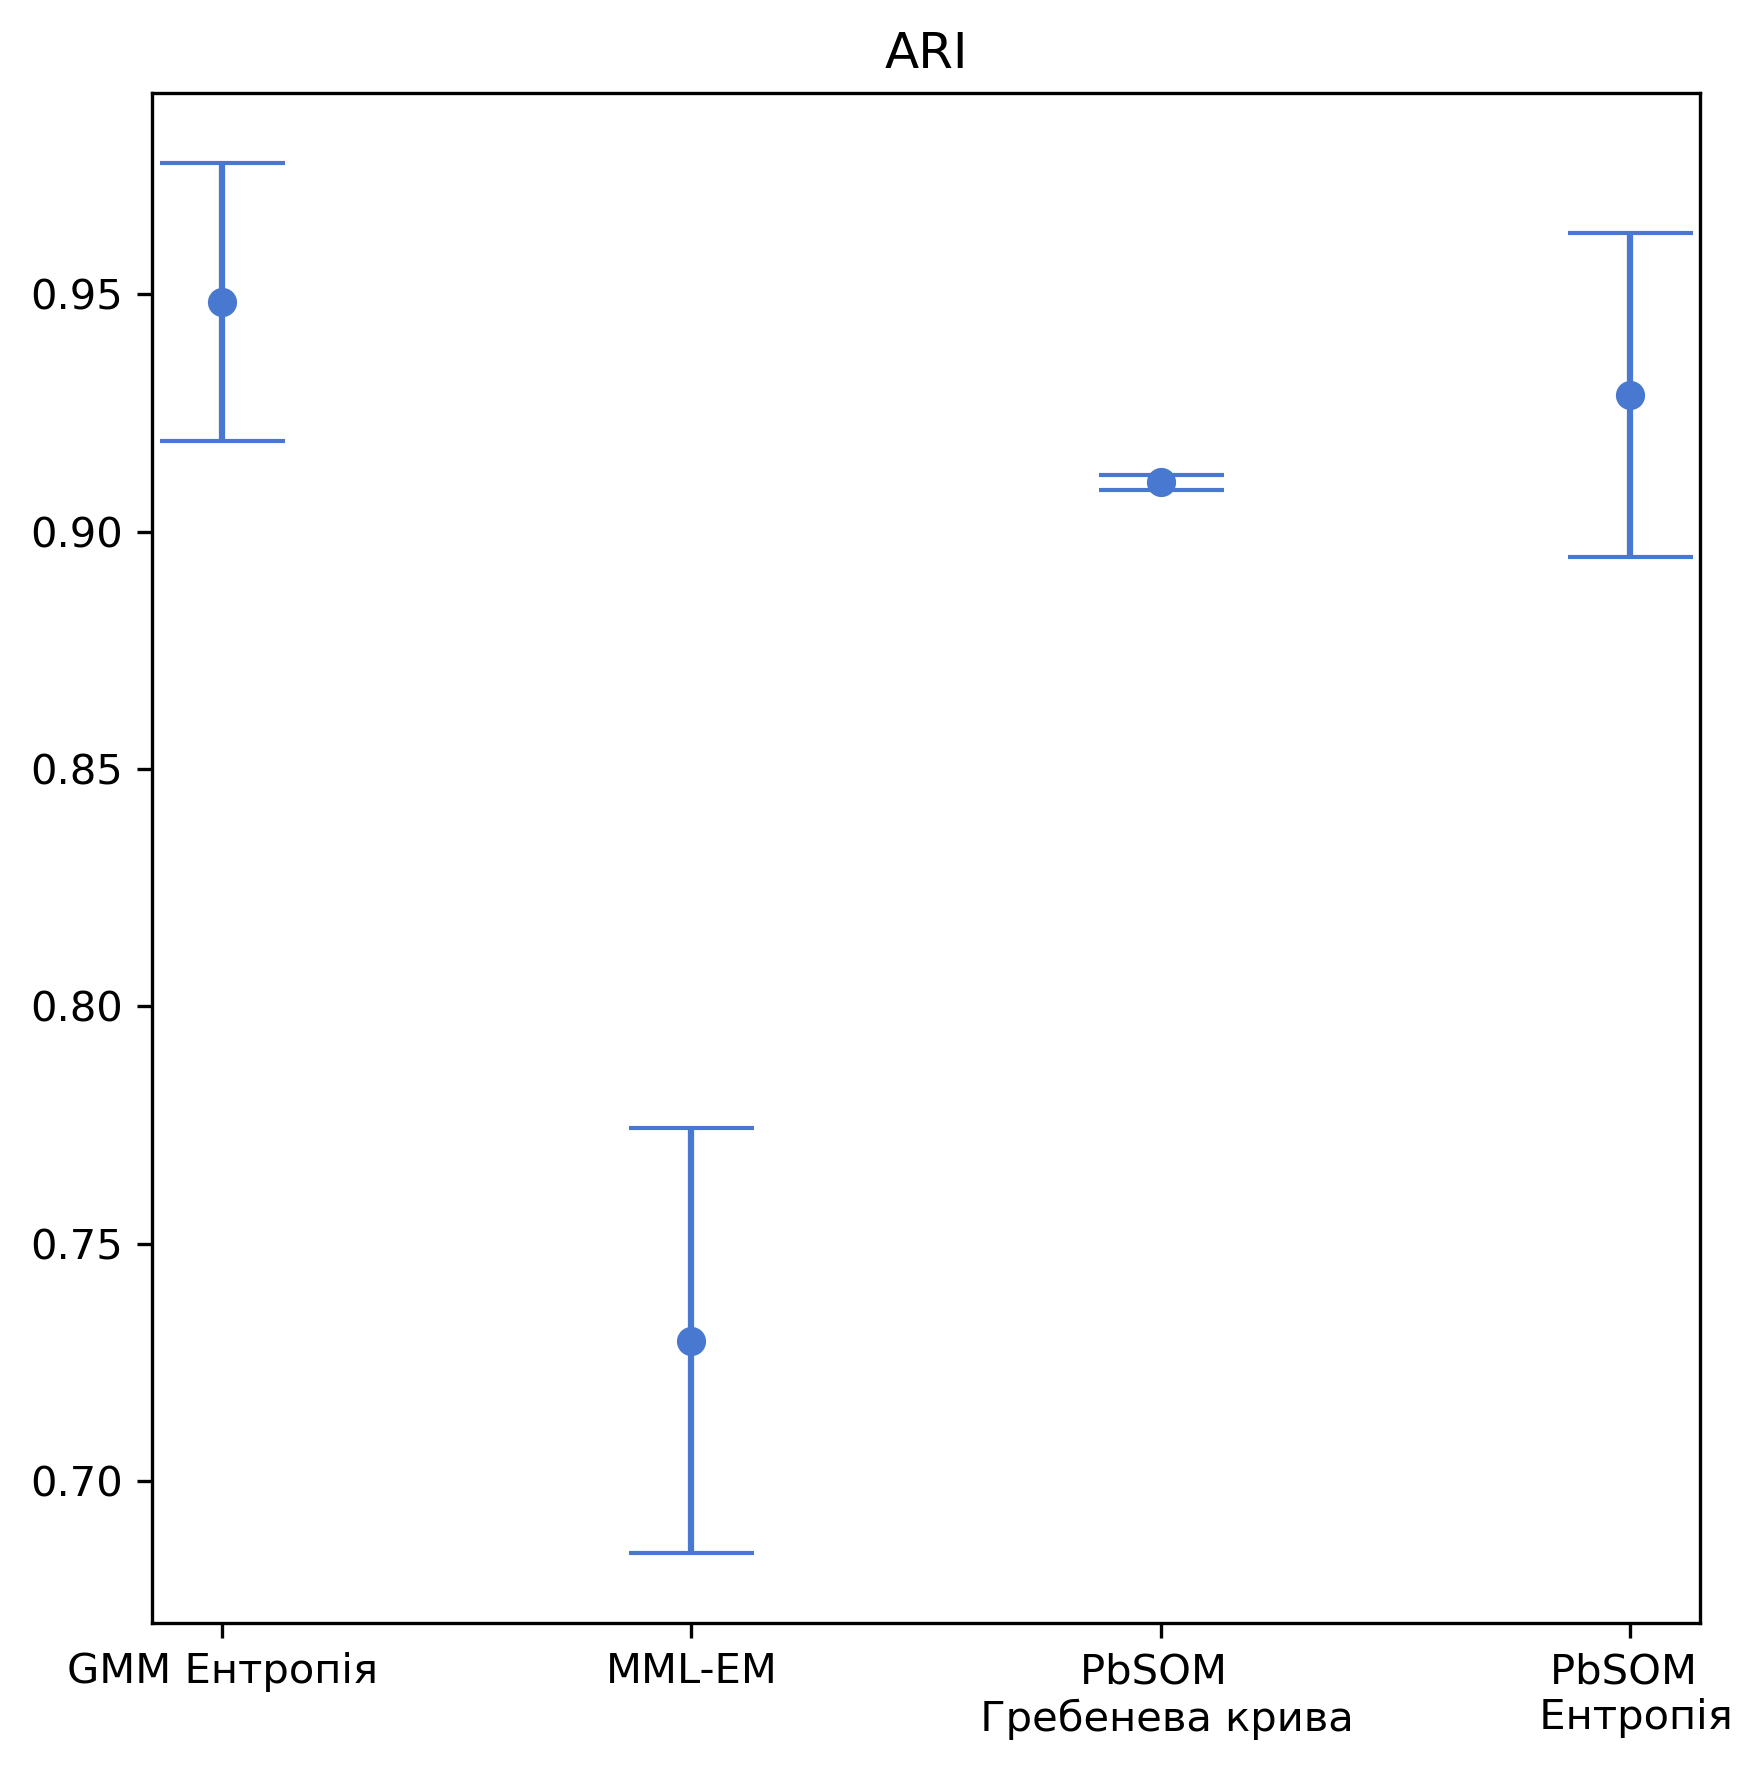

In [31]:
values_flat = statistics.flatten()
group_labels = np.repeat(['MML-EM', 'PbSOM \n Ентропія', 'PbSOM \n Гребенева крива', 'GMM Ентропія'], statistics.shape[1])

# Calculate mean and standard deviation for each group
group_means = [np.mean(values_flat[group_labels == label]) for label in np.unique(group_labels)]
group_std = [np.std(values_flat[group_labels == label]) for label in np.unique(group_labels)]

# Create the error bar plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.errorbar(np.unique(group_labels), group_means, yerr=group_std, fmt='o', capsize=15)
ax.set_title("ARI")
plt.tight_layout()
plt.savefig('../Images/artificial_data_res.png', dpi=300)